# Drawing

## (1) 盒鬚圖
不同隱藏層神經元數量 (n=[1,20])下的 30 次建模結果盒鬚圖

In [1]:
from module.draw.draw import display_boxplot
name_experiment = "2024_0608_1257"

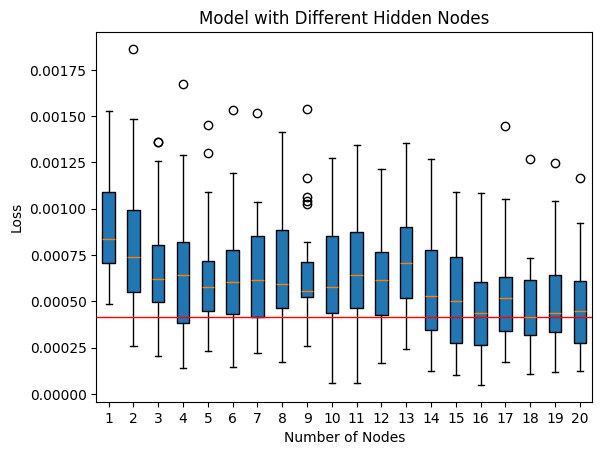

In [2]:
ttl_loss_in = display_boxplot(name_experiment, type_loss=0)
# ttl_loss_in

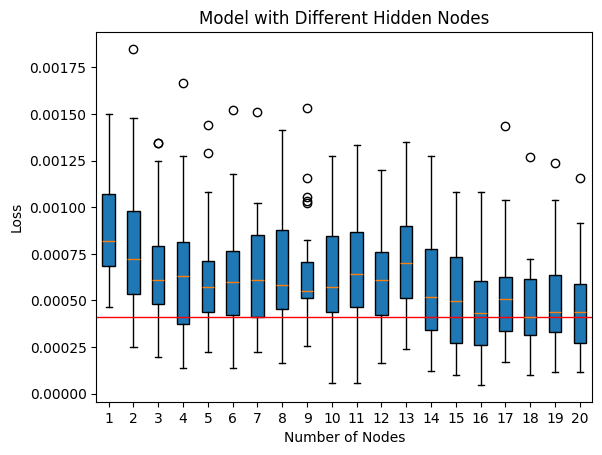

In [3]:
ttl_loss_out = display_boxplot(name_experiment, type_loss=1)
# ttl_loss_out

由上面兩張圖可以看出， <br>
無論是 best in-sample loss 或 best out-of-sample loss， <br>
當 n=1 時，其 loss 的平均、盒子的寬度，皆為最小值。<br>
<br>
故接下來探討 <b>n=1</b> 時的狀況。

## (2) 真實 vs 預測
最佳隱藏層數量下，30 次建模結果最佳解的真實與預測解比較

In [4]:
import numpy as np
from module.for_model.checkpoint import get_best_model
from module.for_dataset.create_dataset import create_dataset
from module.for_dataset.normalization import normalization

### 調出 best model 的 best checkpoint 的參數

In [5]:
name_experiment = "2024_0608_1257"
n = 1
nn_best, _ = get_best_model(name_experiment, n)

### 建立其他沒看過的資料

In [6]:
# 建立其他沒看過的資料
# (之前 random seed 設 0，這次要設不一樣)

random_seed = 1
num_analysis = 5
num_data = int(num_analysis/0.8)

X, Y, _, _ = create_dataset(random_seed, num_data, "sum")

# reshape for the model output
Y = Y.reshape((-1,1))

# normalize
normalizer = normalization(X)
X_n = normalizer.normalize(X)
Y_n = normalizer.normalize(Y)

X_n

array([[0.01186595, 0.65823445],
       [0.09923067, 1.        ],
       [0.        , 0.53214239],
       [0.9919155 , 0.43265093],
       [0.68483505, 0.68196636]])

### 比較不同輸入時，預測值、真實值的差異

In [7]:
# 稍微計算一下 loss
loss_average = nn_best.evaluate(X_n, Y_n)
loss_average

0.0007307054019220426

In [8]:
# 比較輸入、預測值、標籤
diff = np.zeros(num_analysis, dtype=int)
for x, y, idx in zip(X, Y, range(num_analysis)):
    x_n = normalizer.normalize(x)
    pred = nn_best.forward([x_n])[0]
    y_pred = normalizer.unnormalize(pred)
    y_pred = y_pred.round()
    
    diff[idx] = y[0] - y_pred[0]
    print(f"x = {x}, y_pred = {y_pred[0]}, y = {y[0]}")

diff

x = [1235 6192], y_pred = 7077.0, y = 7427
x = [1905 8813], y_pred = 10630.0, y = 10718
x = [1144 5225], y_pred = 5923.0, y = 6369
x = [8751 4462], y_pred = 12959.0, y = 13213
x = [6396 6374], y_pred = 12580.0, y = 12770


array([350,  88, 446, 254, 190])

誤差「比例」雖不大，但「值」差很多，我猜可能 train 的時候可以選擇下面其中一個方式（意義差不多）
1. learning rate 可以調大一點，
2. loss 應該用 unnormalied 的 data 算

## (3) 學習曲線
最佳隱藏層數量下，30 次建模結果最佳解的學習曲線

In [9]:
import numpy as np
from module.for_model.checkpoint import get_best_model, load_checkpoint
import matplotlib.pyplot as plt

#### 調出 best model 的所有 checkpoint

In [10]:
name_experiment = "2024_0608_1257"
n = 1
_, idx_best = get_best_model(name_experiment, n)
idx_best

17

In [11]:
path_folder = f"checkpoints\\{name_experiment}\\node_{n:02d}"
ttl_loss = load_checkpoint(path_folder, "loss")
ttl_loss = np.array(ttl_loss)
ttl_loss.shape

(30, 21, 2)

#### 畫圖

In [12]:
x = range(ttl_loss.shape[1])
y_loss_in = ttl_loss[idx_best,:,0]      # in-sample loss        # 紅色
y_loss_out = ttl_loss[idx_best,:,1]     # out-of-sample loss    # 藍色

##### 觀察整體
看起來學習曲線下降得非常快

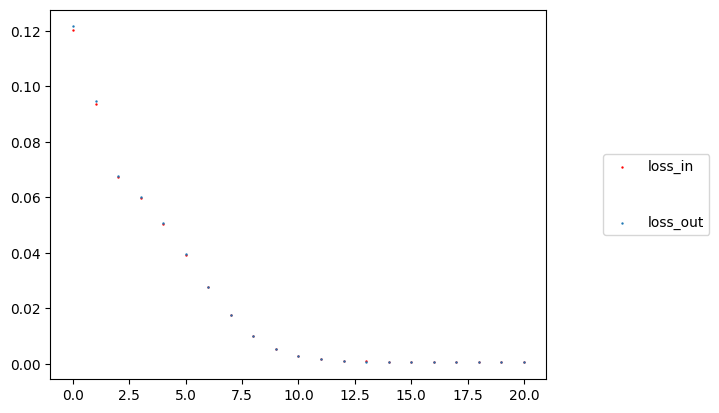

In [13]:
plt.scatter(x, y_loss_in, s=0.5, label="loss_in", color="r")
plt.scatter(x, y_loss_out, s=0.5, label="loss_out")
plt.legend(loc='center left', bbox_to_anchor=(1.1, 0.5), labelspacing=3)

##### 觀察前期
前途曾經發生 loss_out 低於 loss_in 的狀況，很有趣。

(0.045, 0.13)

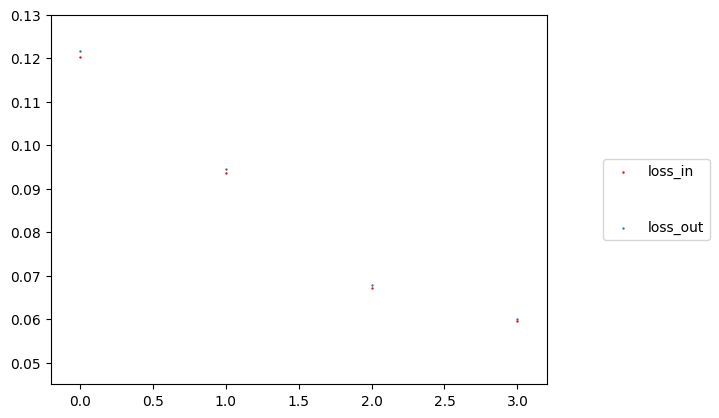

In [14]:
plt.scatter(x, y_loss_in, s=0.5, label="loss_in", color="r")
plt.scatter(x, y_loss_out, s=0.5, label="loss_out")
plt.legend(loc='center left', bbox_to_anchor=(1.1, 0.5), labelspacing=3)
plt.xlim([-0.2,3.2])
plt.ylim([0.045,0.13])

##### 觀察轉折點
loss_out 下降速度逐漸慢於 loss_in，但仍在下降。可能代表有一點 overfitting?
是說整體曲獻跟上一張圖很像，似乎是「指數型狀」的下降速度。

(0.0, 0.006)

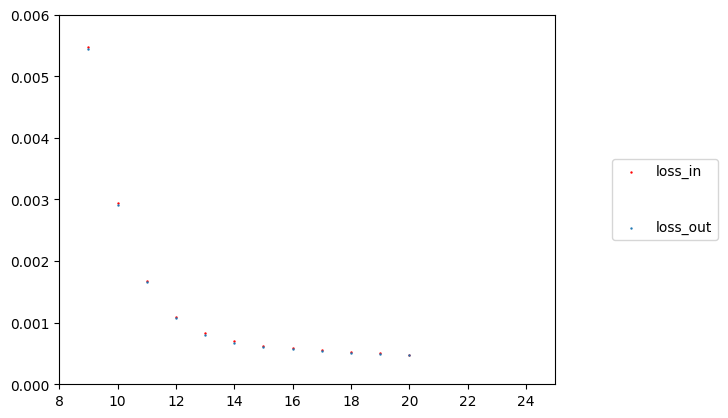

In [15]:
plt.scatter(x, y_loss_in, s=0.5, label="loss_in", color="r")
plt.scatter(x, y_loss_out, s=0.5, label="loss_out")
plt.legend(loc='center left', bbox_to_anchor=(1.1, 0.5), labelspacing=3)
plt.xlim([8,25])
plt.ylim([0.0,0.006])

##### 觀察後期
loss_out 又低於 loss_in 了，不確定原因。

(6.5e-05, 6.8e-05)

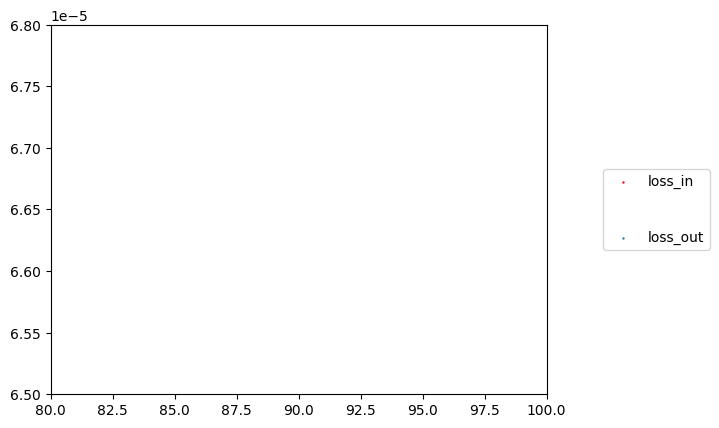

In [16]:
plt.scatter(x, y_loss_in, s=0.5, label="loss_in", color="r")
plt.scatter(x, y_loss_out, s=0.5, label="loss_out")
plt.legend(loc='center left', bbox_to_anchor=(1.1, 0.5), labelspacing=3)
plt.xlim([80,100])
plt.ylim([6.5e-5,6.8e-5])

## (4) Error Histogram
最佳隱藏層數量下，30 次建模結果最佳解的 Error Histogram。

In [17]:
import numpy as np
from module.for_model.checkpoint import get_best_model
from module.for_dataset.create_dataset import create_dataset
from module.for_dataset.normalization import normalization
import matplotlib.pyplot as plt

### 調出 best model 的 best checkpoint 的參數

In [18]:
name_experiment = "2024_0608_1257"
n = 16
nn_best, _ = get_best_model(name_experiment, n)

### 建立其他沒看過的資料

In [19]:
# 建立其他沒看過的資料
# (之前 random seed 設 0，這次要設不一樣)

random_seed = 2
num_analysis = 10000
num_data = int(num_analysis/0.8)

X, Y, _, _ = create_dataset(random_seed, num_data, "sum")

# reshape for the model output
Y = Y.reshape((-1,1))

# normalize
normalizer = normalization(X)
X_n = normalizer.normalize(X)
Y_n = normalizer.normalize(Y)

X_n

array([[0.81529229, 0.28617471],
       [0.73760836, 0.27939542],
       [0.12213825, 0.5301178 ],
       ...,
       [0.96010224, 0.78839742],
       [0.73916426, 0.93231829],
       [0.46176928, 0.12991776]])

### 取得 error

In [20]:
# 取得 error
ttl_error = np.zeros(num_analysis, dtype=int)
for x_n, y, idx in zip(X_n, Y, range(num_analysis)):
    pred = nn_best.forward([x_n])
    y_pred = normalizer.unnormalize(pred)
    y_pred = y_pred.round()
    ttl_error[idx] = y[0] - y_pred[0,0]
ttl_error

array([-51, -54,  -6, ..., 150, 148,  34])

(array([2592., 2529., 2360., 1944.,  232.,  146.,   99.,   50.,   29.,
          19.]),
 array([-128. ,  -66.7,   -5.4,   55.9,  117.2,  178.5,  239.8,  301.1,
         362.4,  423.7,  485. ]),
 <BarContainer object of 10 artists>)

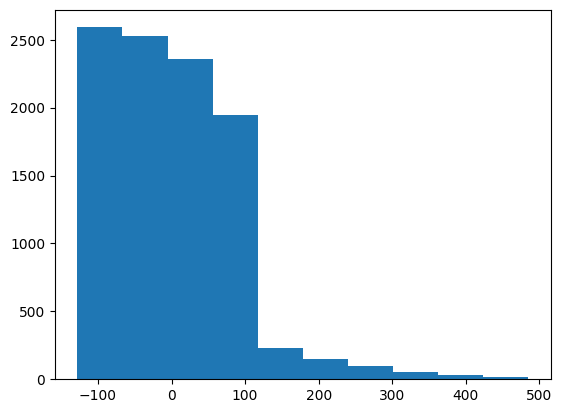

In [21]:
# 畫圖
plt.hist(ttl_error)

從長調圖可以看出，大概四成的情況下，預測值都比真實值大